**Imports and Data Loading**

In [76]:
from google.colab import drive
from google.colab import auth
from google.auth import default
import os

drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/Colab Notebooks/Captcha CNN and OCR')

Mounted at /content/drive/


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

# tensorflow loads keras lazily, resulting in an IDE bug
from tensorflow import keras
from tensorflow.keras import layers, applications
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers, losses, activations
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from sklearn.utils import compute_class_weight

In [79]:
data_path = './data/reCAPTCHA/images'

**Image Preprocessing**

In [81]:
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
    zoom_range=0.05,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    validation_split=0.20
)

valid_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
    validation_split=0.20
)

# Training data generator
train_dataset = train_datagen.flow_from_directory(
    directory=data_path,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

# Validation data generator
test_dataset = valid_datagen.flow_from_directory(
    directory=data_path,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)


Found 9388 images belonging to 12 classes.
Found 2342 images belonging to 12 classes.


In [82]:
# creating the labels

labels = train_dataset.class_indices
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'Bicycle',
 1: 'Bridge',
 2: 'Bus',
 3: 'Car',
 4: 'Chimney',
 5: 'Crosswalk',
 6: 'Hydrant',
 7: 'Motorcycle',
 8: 'Other',
 9: 'Palm',
 10: 'Stair',
 11: 'Traffic Light'}

**Hyper-Parameters**

In [83]:
initial_epochs = 10
total_epochs = 100
learning_rate = 1e-3

early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,         # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,         # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001,     # Lower bound on the learning rate
)

ROWS = 150
COLS = 150
NUM_CLASSES = 12

**CNN Model**

In [84]:
class InceptionV3Model(Model):

  '''
  Convolutional Neural Network

  '''
  def __init__(self, model_input_shape, num_classes, inception_weights, trainable_layers=150):
    super(InceptionV3Model, self).__init__()
    self.model_input_shape = model_input_shape
    self.num_classes = num_classes
    self.inception_weights = inception_weights

    # Load the InceptionV3 base model
    self.base_model = applications.InceptionV3(weights=self.inception_weights,
                                                include_top=False,
                                                input_shape=self.model_input_shape)
    # Set the trainable layers
    for layer in self.base_model.layers[:trainable_layers]:
        layer.trainable = False
    for layer in self.base_model.layers[trainable_layers:]:
        layer.trainable = True

    # Add custom layers on top of InceptionV3
    self.global_pool = GlobalAveragePooling2D()
    self.dropout1 = Dropout(0.7)
    self.dense1 = Dense(256, activation='relu')
    self.dropout2 = Dropout(0.5)
    self.dense2 = Dense(num_classes, activation='softmax')

  def call(self, inputs):

    '''
      Forward pass through CNN

    '''
    x = self.base_model(inputs)
    x = self.global_pool(x)
    x = self.dropout1(x)
    x = self.dense1(x)
    x = self.dropout2(x)
    return self.dense2(x)

  def unfreeze_more_layers(self, additional_layers=50):
    '''
    After some initial training epochs, call this method to unfreeze more layers

    '''
    for layer in self.base_model.layers[-additional_layers:]:
        layer.trainable = True

  def compile_model(self, learning_rate):
    self.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=learning_rate, momentum=0.9),
              metrics=['accuracy'])

**Training Loop**

In [85]:
train_classes = train_dataset.classes
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_classes),
    y = train_classes
)
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 1.2537393162393162,
 1: 1.8321623731459797,
 2: 0.8081955922865014,
 3: 0.27479217890176794,
 4: 7.823333333333333,
 5: 0.7886424731182796,
 6: 1.02668416447944,
 7: 12.035897435897436,
 8: 0.7297885572139303,
 9: 1.073159579332419,
 10: 4.629191321499014,
 11: 1.2359136387572407}

In [86]:
inception_weights = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = InceptionV3Model(model_input_shape=(ROWS, COLS, 3), num_classes=NUM_CLASSES, inception_weights=inception_weights)
model.compile_model(learning_rate)

In [87]:
history = model.fit(train_dataset,
                      validation_data=test_dataset,
                      class_weight = class_weights,
                      callbacks=[early_stopping, reduce_lr],
                      epochs=initial_epochs,
                      shuffle=True)

Epoch 1/10
147/147 [==============================] - 81s 489ms/step - loss: 2.4090 - accuracy: 0.1763 - val_loss: 2.8550 - val_accuracy: 0.2451 - lr: 0.0100
Epoch 2/10
147/147 [==============================] - 72s 491ms/step - loss: 1.6340 - accuracy: 0.3682 - val_loss: 2.0966 - val_accuracy: 0.3019 - lr: 0.0100
Epoch 3/10
147/147 [==============================] - 71s 485ms/step - loss: 1.2217 - accuracy: 0.5185 - val_loss: 1.1535 - val_accuracy: 0.6153 - lr: 0.0100
Epoch 4/10
147/147 [==============================] - 71s 485ms/step - loss: 0.9570 - accuracy: 0.6183 - val_loss: 1.1335 - val_accuracy: 0.6576 - lr: 0.0100
Epoch 5/10
147/147 [==============================] - 72s 489ms/step - loss: 0.9085 - accuracy: 0.6452 - val_loss: 1.2297 - val_accuracy: 0.6383 - lr: 0.0100
Epoch 6/10
147/147 [==============================] - 72s 490ms/step - loss: 0.7847 - accuracy: 0.6929 - val_loss: 0.8865 - val_accuracy: 0.7306 - lr: 0.0100
Epoch 7/10
147/147 [==============================] 

In [88]:
# Unfreeze more layers for fine-tuning
model.unfreeze_more_layers(additional_layers=50)

# Compile the model again with a reduced learning rate for fine-tuning
model.compile_model(learning_rate=1e-4)

history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    class_weight = class_weights,
                    callbacks=[early_stopping, reduce_lr],
                    epochs=total_epochs - initial_epochs,
                    shuffle=True)

Epoch 1/90
147/147 [==============================] - 80s 487ms/step - loss: 0.6108 - accuracy: 0.7462 - val_loss: 0.7626 - val_accuracy: 0.7643 - lr: 0.0100
Epoch 2/90
147/147 [==============================] - 72s 487ms/step - loss: 0.5787 - accuracy: 0.7471 - val_loss: 0.7766 - val_accuracy: 0.7626 - lr: 0.0100
Epoch 3/90
147/147 [==============================] - 72s 492ms/step - loss: 0.5127 - accuracy: 0.7641 - val_loss: 0.7835 - val_accuracy: 0.7652 - lr: 0.0100
Epoch 4/90
147/147 [==============================] - 71s 481ms/step - loss: 0.5030 - accuracy: 0.7729 - val_loss: 0.8421 - val_accuracy: 0.7506 - lr: 0.0100
Epoch 5/90
147/147 [==============================] - 71s 485ms/step - loss: 0.5590 - accuracy: 0.7624 - val_loss: 0.8123 - val_accuracy: 0.7694 - lr: 0.0100
Epoch 6/90
147/147 [==============================] - 72s 490ms/step - loss: 0.5216 - accuracy: 0.7646 - val_loss: 0.7715 - val_accuracy: 0.7626 - lr: 0.0100
Epoch 7/90
147/147 [==============================] 

In [89]:
model.save('my_recaptcha_model.keras')

**Testing**

In [90]:
model.load_weights('my_recaptcha_model.keras')

In [91]:
validation_loss, validation_accuracy = model.evaluate(test_dataset)
print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

37/37 [==============================] - 5s 145ms/step - loss: 0.6270 - accuracy: 0.8160
Validation Loss: 0.6269693970680237
Validation Accuracy: 81.60%


2/2 [==============================] - 0s 17ms/step


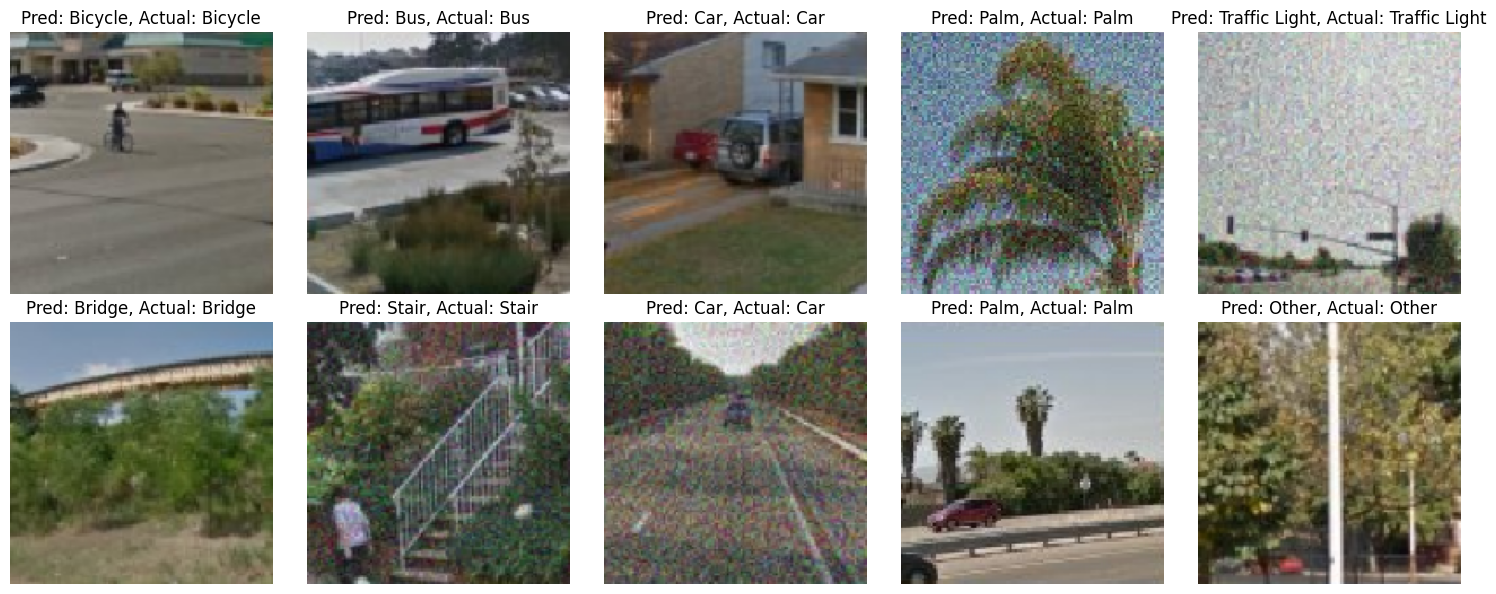

In [102]:
for batch in test_dataset:
    batch_images, batch_labels = batch
    preds = model.predict(batch_images)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(batch_labels, axis=1)

    # Plot the images with predictions and actual labels
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flatten()):
        if i < len(batch_images):
            pred, true = labels[pred_labels[i]], labels[true_labels[i]]
            img = batch_images[i]
            ax.imshow(img)
            ax.set_title(f"Pred: {pred}, Actual: {true}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()
    break;